In [26]:
import numpy as np
from tqdm import tqdm
from utils import *
import torch
import math
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"Using device {device}")

%load_ext autoreload
%autoreload 2

BOND_LENGTH = 1.0

#NR_OF_MOLS = 3
#energy_lut = torch.tensor([
#    [-2, 1, 1],
#    [1, -2, 1],
#    [1, 1, -2]
#], device=device)

NR_OF_MOLS = 2
energy_lut = torch.tensor([
    [-1, 1],
    [1, -1]
], device=device)

Using device cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def compute_sq_distances(positions):
    pos_i = torch.unsqueeze(positions, 2) # [B, N, 1, 3]
    pos_j = torch.unsqueeze(positions, 1) # [B, 1, N, 3]
    diff = pos_i - pos_j # [B, N, N, 3]
    dist_sq = (diff * diff).sum(dim=-1)
    return dist_sq

In [28]:
def compute_bond_energy(positions):
    offsets = positions[:, :-1, :] - positions[:, 1:, :] # [B, N-1, 3]
    dist_sq = (offsets * offsets).sum(dim=-1) # [B, N-1]
    dist = torch.sqrt(dist_sq + 1e-9)
    bond_deviation = dist - BOND_LENGTH
    return (bond_deviation * bond_deviation).sum(dim=1)

In [29]:
def compute_interaction_energy(sq_dist, pairwise_coef):
    pairwise_energy = pairwise_coef / (sq_dist + 1e-9)
    return pairwise_energy.sum(dim=[1, 2])

def compute_repulsion_energy(sq_dist, steric_repulsion_distance, steric_repulsion_strength):
    dist = torch.sqrt(sq_dist + 1e-9)
    steric_overlap = torch.relu(steric_repulsion_distance - dist)
    steric_overlap = torch.triu(steric_overlap, diagonal=1)
    steric_penalty = steric_repulsion_strength * steric_overlap
    return steric_penalty.sum(dim=[1, 2])

In [30]:
def initialize_random_walk(batch_size, length, step_size):
    positions = torch.zeros(batch_size, length, 3, device=device)
    # Leave position of first molecule at (0, 0, 0)
    #positions[:, 1, 0] = BOND_LENGTH # Fix positions of second molecule at (BOND_LENGTH, 0, 0)
    for i in range(1, length):
        offset = torch.nn.functional.normalize(torch.randn(batch_size, 3, device=device), dim=1)
        offset *= step_size
        positions[:, i] = positions[:, i-1] + offset
    return positions

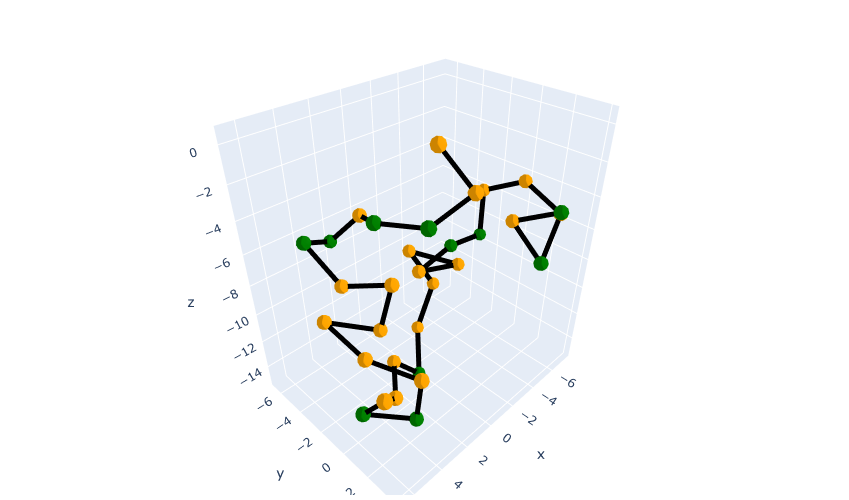

In [31]:
batch_size = 1
sequence = torch.randint(0, NR_OF_MOLS, (32,), device=device)
#sequence = torch.tensor([0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0], dtype=int, device=device)

type_i = torch.unsqueeze(sequence, 1) # [N, 1]
type_j = torch.unsqueeze(sequence, 0) # [1, N]
pairwise_coef = torch.triu(energy_lut[type_i, type_j], diagonal=1) # [N, N]

protein_length = sequence.shape[0]
positions = torch.nn.Parameter(initialize_random_walk(batch_size, protein_length, BOND_LENGTH * 3))

plot_protein(sequence.cpu().numpy(), positions[0].cpu().detach().numpy()).show()

optimizer = torch.optim.Adam([positions], lr=0.1)

In [32]:
trajectory = [positions[0].clone().detach().cpu().numpy()]

start_temperature = 1
end_temperature = .01
temperature_decrease = 0.99
temp_steps = int(math.log(end_temperature / start_temperature, temperature_decrease))
no_temp_steps = 1000
log_interval = 10

temperature = start_temperature
for step in (pbar := tqdm(range(temp_steps + no_temp_steps))):
    
    optimizer.zero_grad()
    sq_dist = compute_sq_distances(positions)
    bond_energy = 100 * compute_bond_energy(positions)
    interaction_energy = compute_interaction_energy(sq_dist, pairwise_coef)
    repulsion_energy = compute_repulsion_energy(sq_dist, steric_repulsion_distance=1, steric_repulsion_strength=100)
    total_energy = bond_energy + interaction_energy + repulsion_energy
    loss = torch.mean(total_energy)
    loss.backward()
    
    # Clip gradient to prevent large steps.
    torch.nn.utils.clip_grad_value_([positions], clip_value=0.1)
    
    optimizer.step()

    if step < temp_steps:
        with torch.no_grad(): 
            positions += torch.randn(positions.shape, device=device) * temperature
    
        temperature *= temperature_decrease

    if step == 0 or (step+1) % log_interval == 0:
        trajectory.append(positions[0].clone().detach().cpu().numpy())
    
    pbar.set_description(f"T: {temperature if step < temp_steps else 0:6.4f}, Loss: {loss:6.2f}, bond: {torch.mean(bond_energy) * 10:6.2f}, interaction: {torch.mean(interaction_energy):6.2f}, repulsion: {torch.mean(repulsion_energy):6.2f}, range: {torch.max(total_energy)-torch.min(total_energy):8.2f}")
    
#from torchviz import make_dot
#make_dot(total_energy).view()

print(total_energy)
    
#plot_protein(sequence[0].cpu().numpy(), positions[0].cpu().detach().numpy())
#print(bond_energy, interaction_energy)

T: 0.0000, Loss:  17.64, bond:  72.13, interaction:  -6.67, repulsion:  17.09, range:     0.00: 100%|█| 1458/1458 [00:4


tensor([17.6350], device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
plot_protein_trajectory(trajectory, sequence.cpu().numpy())

In [ ]:
#plot_batch(sequence.cpu().numpy(), positions.cpu().detach().numpy())